In [56]:
# 1. Data Manipulation
import numpy as np
import pandas as pd

# 2. Data Vizualisation
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns



# 3. Algorithms
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC


# 4. Metrics
from sklearn import metrics, model_selection

# 5. Feature Encoding
from sklearn.preprocessing import LabelEncoder

# 6. Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

%matplotlib inline
style.use('dark_background')

In [2]:
finance_train = pd.read_csv("finance_train_data.csv")

In [3]:
# function to get all relevant information about the dataframe

def get_df_info(df, include_unique=True):
    column = [col for col in df.columns]
    column_type = [type(cell) for cell in df.loc[0,:]]
    null_count = [df[col].isna().sum() for col in df.columns]
    null_percent = [((df[col].isna().sum()/df.shape[0])*100) for col in df.columns]
    if include_unique:
        unique = [df[col].unique() for col in df.columns]
        unique_count = [df[col].nunique() for col in df.columns]
        df_info = pd.DataFrame({'column': column, 'column_type': column_type,
                                'null_count': null_count, 'unique_count': unique_count,
                                'null_percent': null_percent, 'unique_values': unique})
    else:
        df_info = pd.DataFrame({'column': column, 'column_type': column_type,
                                'null_count': null_count, 'null_percent': null_percent})
        
    return df_info
    

get_df_info(finance_train)

,column,column_type,null_count,unique_count,null_percent,unique_values
0,Loan_ID,<class 'str'>,0,614,0.000000,"[LP001002, LP001003, LP001005, LP001006, LP001..."
1,Gender,<class 'str'>,13,2,2.117264,"[Male, Female, nan]"
2,Married,<class 'str'>,3,2,0.488599,"[No, Yes, nan]"
3,Dependents,<class 'str'>,15,4,2.442997,"[0, 1, 2, 3+, nan]"
4,Education,<class 'str'>,0,2,0.000000,"[Graduate, Not Graduate]"
5,Self_Employed,<class 'str'>,32,2,5.211726,"[No, Yes, nan]"
6,ApplicantIncome,<class 'numpy.int64'>,0,505,0.000000,"[5849, 4583, 3000, 2583, 6000, 5417, 2333, 303..."
7,CoapplicantIncome,<class 'numpy.float64'>,0,287,0.000000,"[0.0, 1508.0, 2358.0, 4196.0, 1516.0, 2504.0, ..."
8,LoanAmount,<class 'numpy.float64'>,22,203,3.583062,"[nan, 128.0, 66.0, 120.0, 141.0, 267.0, 95.0, ..."
9,Loan_Amount_Term,<class 'numpy.float64'>,14,10,2.280130,"[360.0, 120.0, 240.0, nan, 180.0, 60.0, 300.0,..."


To perform our Data Analysis, let's create an empty DataFrame to which we will keep adding the features one by one.

In [4]:
df_finance = pd.DataFrame()

Let's explore each feature individually

In [5]:
# Function to make distribution and count plots

def plot_(data, col, figsize=(20,2), hue=False):
    if hue:
        sns.displot(x=col, data=data, hue='Loan_Status', height=8)
    else:
        plt.figure(figsize=figsize)
        sns.countplot(y=col, data=data)

In [6]:
#Function to calculate the proportion of "Yes" values for features with binary output against Loan_status

def feature_approval_proportion(df, col, yes=1, no=0, label='Loan_Status'):
    
    yes_count, no_count = df[col].value_counts()[yes], df[col].value_counts()[no]

    yes_prop = (df[df[label] == 1][col] == yes).sum()/ yes_count
    no_prop = (df[df[label] == 1][col] == no).sum()/ no_count

    return yes_prop*100, no_prop*100

Target Feature: Loan_Status (whether the loan was approved or not)
This is what we want out model to predict.

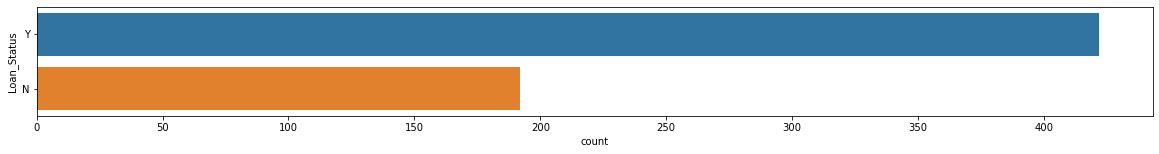

In [7]:
plot_(data=finance_train, col='Loan_Status')

In [8]:
# Let's encode 1 for Loan Approved, 0 for not approved and add this feature to out new dataframe

df_finance['Loan_Status'] = finance_train['Loan_Status']
df_finance['Loan_Status'] = np.where(df_finance['Loan_Status'] == 'Y', 1, 0)

Feature-1: Loan_ID
We have 601 unique values for this feature indicating that there is no underlying pattern behind its occurence and hence we do not add it to out new DataFrame

Feature-2: Married (Y/N)

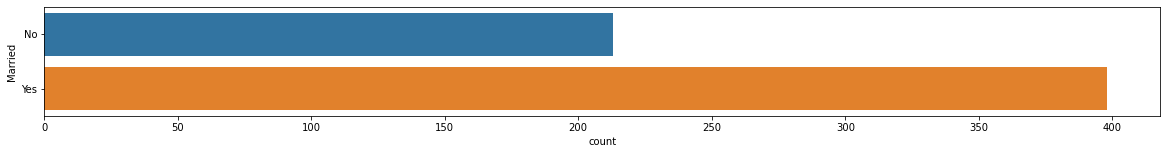

In [9]:
# Let's look at the distribution of Married

plot_(finance_train, col='Married')

Married does not have any missing values. Therefore, let's encode 1 if an individual is married, 0 otherwise and add it to out new DataFrame

In [10]:
df_finance['Married'] = finance_train['Married']
df_finance['Married'] = np.where(df_finance['Married'] == 'Yes', 1, 0)
df_finance.head()

,Loan_Status,Married
0,1,0
1,0,1
2,1,1
3,1,1
4,1,0


How does the Marital Status look when compared to Loan_Status ?

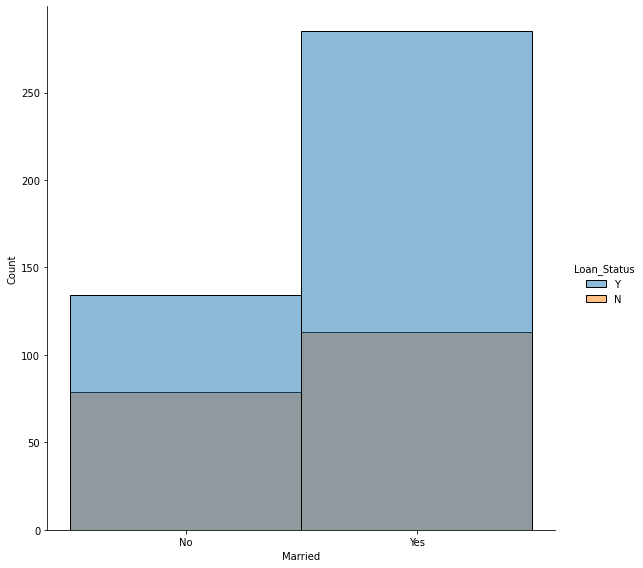

In [11]:
plot_(data=finance_train, col='Married', hue=True)

From the plot, it looks like, Married individual is more likely to get approved. Let's verify this numerically. We will use the function that we created above.

In [12]:
#Percent of married and unmarried whose status was YES

marr, unmarr = feature_approval_proportion(df_finance, col='Married')

print("{}% married and {}% unmarried got approved".format(marr, unmarr))

71.60804020100502% married and 63.42592592592593% unmarried got approved


Hence, our hypothesis that a married individual is more likely to get approved seems correct.

Feature-3: Education (Graduate/Not Graduate)

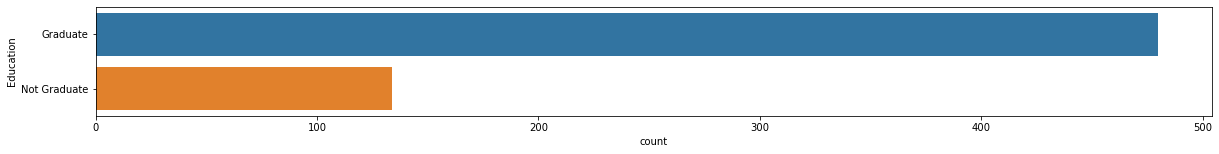

In [13]:
# Distribution of Married

plot_(finance_train, col='Education')

Education has 0 missing values. Encoding 1 for Graduate, 0 for Not Graduate and adding it to our new DataFrame.

In [14]:
df_finance['Graduate'] = finance_train['Education']
df_finance['Graduate'] = np.where(df_finance['Graduate'] == 'Graduate', 1, 0)
df_finance.head()

,Loan_Status,Married,Graduate
0,1,0,1
1,0,1,1
2,1,1,1
3,1,1,0
4,1,0,1


Feature-4: Property_Area

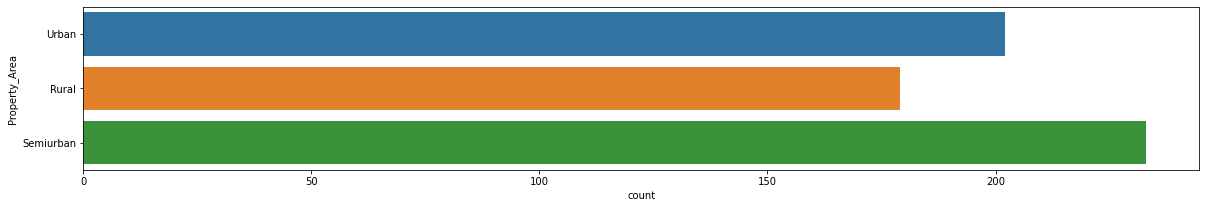

In [15]:
plot_(data=finance_train, col='Property_Area', hue=False, figsize=(20,3))

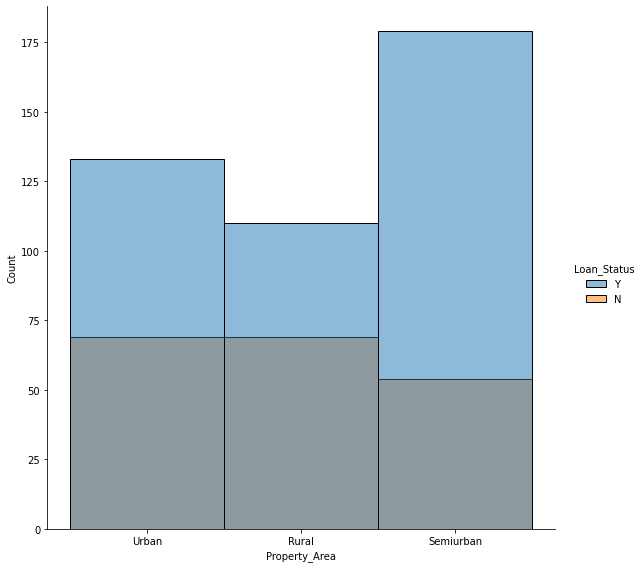

In [16]:
plot_(data=finance_train, col='Property_Area', hue=True, figsize=(20,3))

From the above graph, we observe that people from Semiurban area have a greater chance of Loan_approval. Therefore, while encoding Property_Area into numbers, we can give the most weight to Semiurban.

In [17]:
# Encoding 1 for Rural, 2 for Urban and 3 for Semiurban and adding it to the new DataFrame

df_finance['Property_Area'] = finance_train['Property_Area'].replace({'Semiurban': 3,
                                                                     'Urban': 2,
                                                                     'Rural': 1})
df_finance.head()

,Loan_Status,Married,Graduate,Property_Area
0,1,0,1,2
1,0,1,1,1
2,1,1,1,2
3,1,1,0,2
4,1,0,1,2


Feature-5: ApplicantIncome

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Loan_Status'>

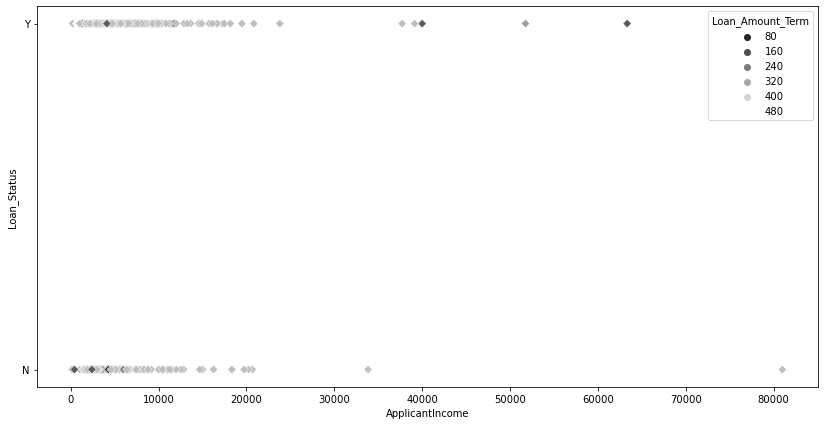

In [18]:
plt.figure(figsize=(14,7))
sns.scatterplot(x='ApplicantIncome', y='Loan_Status', data=finance_train, hue='Loan_Amount_Term', palette='gray', marker="D")

<AxesSubplot:ylabel='Frequency'>

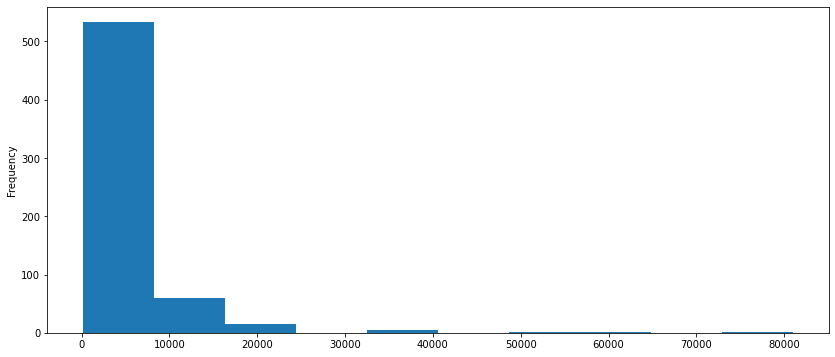

In [19]:
finance_train.ApplicantIncome.plot(kind='hist', figsize=(14,6))

Applicant Income is skewed towards the right (+vely)

In [20]:
finance_train.ApplicantIncome.describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

75% of the Applicants have an income <5780. The maximum income is 81000 indicating a possibility of outliers with respect to the Loan_Status. Therefore, we can discretize the ApplicantIncome by dividing it into 5 categories where Category 1 is the lowest income group and Category 5 is the highest income group.

In [24]:
# Discretizing the Applicant_Income into 5 categories and adding it to our new DataFrame

df_finance['Applicant_Income_Category'] = pd.qcut(finance_train.ApplicantIncome, 5, labels=[1,2,3,4,5])
df_finance.head()

,Loan_Status,Married,Graduate,Property_Area,Applicant_Income_Category
0,1,0,1,2,4
1,0,1,1,1,4
2,1,1,1,2,2
3,1,1,0,2,1
4,1,0,1,2,4


Feature-6: CoapplicantIncome
We have a lot of unique values for CoapplicantIncome. Let's try to see the impact on Loan_Status

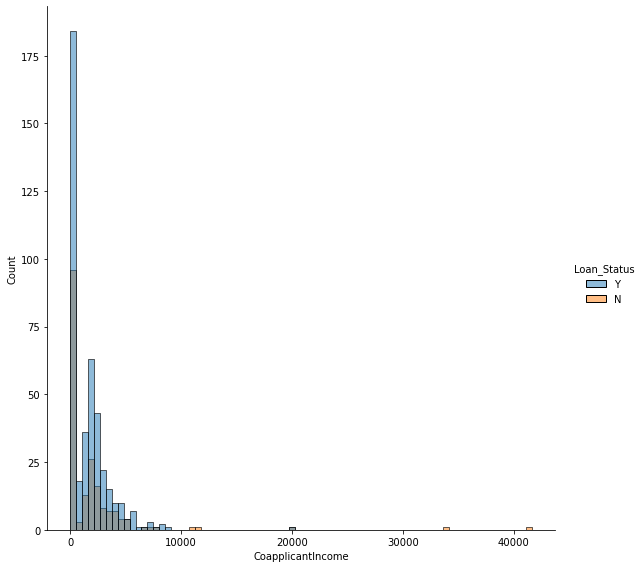

In [25]:
plot_(data=finance_train, col='CoapplicantIncome', figsize=(25,15), hue=True)

In [26]:
finance_train.CoapplicantIncome.value_counts(normalize=True).head(10)

0.0       0.444625
2500.0    0.008143
2083.0    0.008143
1666.0    0.008143
2250.0    0.004886
1750.0    0.004886
1800.0    0.004886
1625.0    0.004886
2333.0    0.004886
1459.0    0.004886
Name: CoapplicantIncome, dtype: float64

44% of the values in CoapplicantIncome are 0. Let's dig deep to see if there's any significant difference between 0 and non-zero CoapplicantIncome

In [27]:
# Proportion of Approved when CoapplicantIncome is 0
print(" Coapplicant Income is zero:   ", end="   ")

coapp_zero = finance_train[finance_train.CoapplicantIncome == 0].shape[0]            # number of rows with 0 copp income
print(finance_train[(finance_train['CoapplicantIncome'] == 0) & (finance_train['Loan_Status'] == 'Y')].shape[0] / coapp_zero) 


# Proportion of Approved when CoapplicantIncome is non-zero
print(" Coapplicant Income is non-zero: ", end=" ")

coapp_non_zero = finance_train[finance_train.CoapplicantIncome != 0].shape[0]        # number of rows with non-zero coapp income
print(finance_train[(finance_train['CoapplicantIncome'] != 0) & (finance_train['Loan_Status'] == 'Y')].shape[0] / coapp_non_zero)

 Coapplicant Income is zero:      0.6483516483516484
 Coapplicant Income is non-zero:  0.718475073313783


There does seem to be a higher proportion of people who get approval if their Coapplicant's Income is non-zero. Is there a relation between higher Coapplicant Income and Loan_Status? Let's check.

<AxesSubplot:xlabel='Loan_Status', ylabel='CoapplicantIncome'>

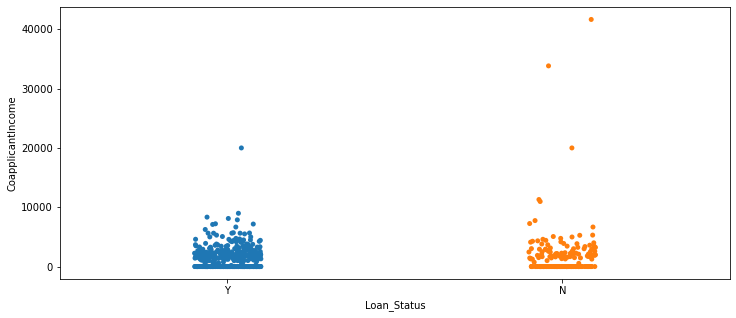

In [28]:
plt.figure(figsize=(12,5))
sns.stripplot(y='CoapplicantIncome', x='Loan_Status', data=finance_train)

Feature_Engineering : There doesn't seem to be much increase in the probability of Loan getting approved as the CoapplicantIncome increases. Therefore, we create a new feature which is 1 if CoapplicantIncome is non-zero, 0 otherwise.

In [29]:
df_finance['Coapplicant_Income_exists'] = finance_train['CoapplicantIncome']
df_finance['Coapplicant_Income_exists'] = np.where(df_finance.Coapplicant_Income_exists == 0, 0, 1)
df_finance.head()

,Loan_Status,Married,Graduate,Property_Area,Applicant_Income_Category,Coapplicant_Income_exists
0,1,0,1,2,4,0
1,0,1,1,1,4,1
2,1,1,1,2,2,0
3,1,1,0,2,1,1
4,1,0,1,2,4,0


Feature-7: Gender

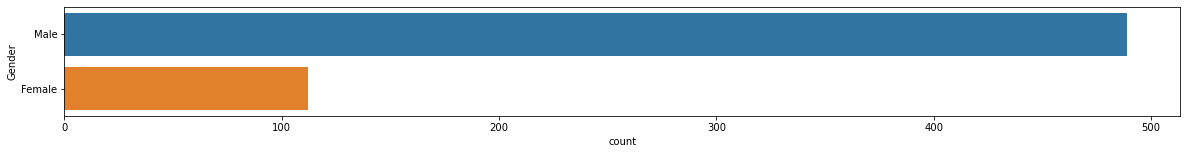

In [30]:
plot_(data=finance_train, hue=False, col='Gender')

In [31]:
finance_train.Gender.value_counts(dropna=False)

Male      489
Female    112
NaN        13
Name: Gender, dtype: int64

About 80% of applicants are Males. Therefore, we will try to keep approximately the same ratio while filling the missing values.

In [32]:
np.random.seed(23)
finance_train.Gender = finance_train.Gender.fillna(pd.Series(np.random.choice(['Male', 'Female'], p=[0.8,0.2], size=len(finance_train))))
finance_train.Gender.value_counts(dropna=False)

Male      499
Female    115
Name: Gender, dtype: int64

In [33]:
# Encoding 1 for Males, 0 for Females and adding it to our new DataFrame

df_finance['Male'] = finance_train['Gender']
df_finance['Male'] = np.where(df_finance['Male'] == 'Male', 1, 0)
df_finance.head(6)

,Loan_Status,Married,Graduate,Property_Area,Applicant_Income_Category,Coapplicant_Income_exists,Male
0,1,0,1,2,4,0,1
1,0,1,1,1,4,1,1
2,1,1,1,2,2,0,1
3,1,1,0,2,1,1,1
4,1,0,1,2,4,0,1
5,1,1,1,2,4,1,1


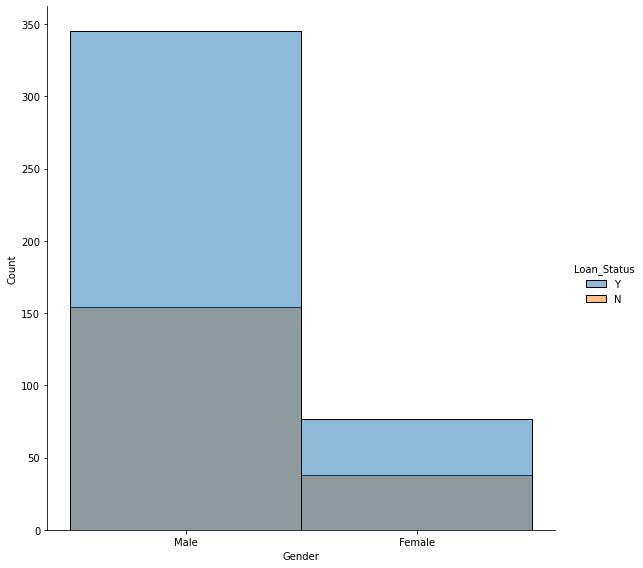

In [34]:
plot_(data=finance_train, col='Gender', hue=True, figsize=(10,8))

Looks like almost same proportion of Male, Females get approved. Let's check

In [35]:
male_approve, female_approve = feature_approval_proportion(df_finance, col='Male')
print("Males approved: {} %\nFemales  approved: {} %".format(male_approve, female_approve))

Males approved: 69.13827655310621 %
Females  approved: 66.95652173913044 %


Therefore, Loan_Status is not very dependent on Gender. 'Advantage:' Even if the actual null values are in a different proportion from what we imputed it wouldn't make much of a differenc

Feature-8 : Dependents

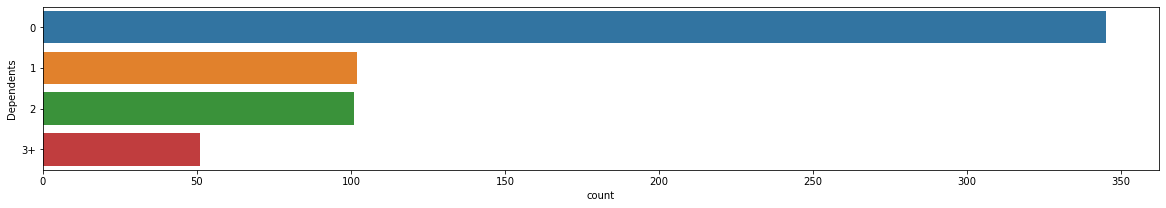

In [36]:
plot_(finance_train, col='Dependents', figsize=(20,3), hue=False)

In [37]:
finance_train.Dependents = finance_train.Dependents.replace('3+','3')
finance_train.Dependents.value_counts(dropna=False)

0      345
1      102
2      101
3       51
NaN     15
Name: Dependents, dtype: int64

Imputing the missing values with 0,1,2 and 3 in the same proportion as they occur in the rest of the data.

In [38]:
np.random.seed(23)
finance_train.Dependents = finance_train.Dependents.fillna(pd.Series(np.random.choice(['0', '1', '2', '3'], p=[0.58, 0.17, 0.17, 0.08], size=len(finance_train))))
finance_train.Dependents.value_counts()

0    357
1    103
2    103
3     51
Name: Dependents, dtype: int64

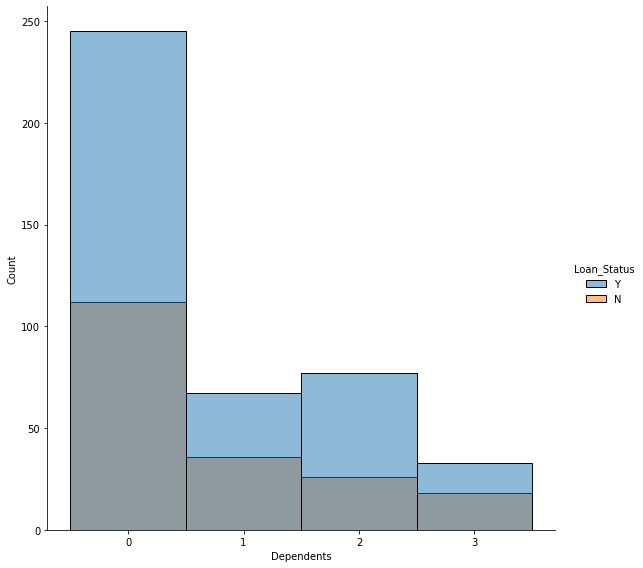

In [39]:
plot_(finance_train, col='Dependents', hue=True)

Individuals having 3 or more Dependents have the least chance of getting their loans approved. 

In [41]:
zero, two  = finance_train.Dependents.value_counts()[0], finance_train.Dependents.value_counts()[1]
one, three = finance_train.Dependents.value_counts()[2], finance_train.Dependents.value_counts()[3]

zero_p = (finance_train[(finance_train.Dependents == '0')]['Loan_Status'] == 'Y').sum() / zero
two_p = (finance_train[(finance_train.Dependents == '1')]['Loan_Status'] == 'Y').sum() / two
one_p = (finance_train[(finance_train.Dependents == '2')]['Loan_Status'] == 'Y').sum() / one
three_p = (finance_train[(finance_train.Dependents == '3')]['Loan_Status'] == 'Y').sum() / three



In [42]:
zero_p

0.6862745098039216

In [43]:
two_p

0.6504854368932039

In [44]:
one_p

0.7475728155339806

In [45]:
three_p

0.6470588235294118

Therefore, we need to encode the Dependents accordingly giving most weight to 1 dependent followed by 0, 2 and 3.

In [46]:
df_finance['Dependents'] = finance_train['Dependents']
df_finance['Dependents'] = df_finance.Dependents.replace({'1': 3, '0': 2, '2': 1, '3': 0})
df_finance.head()

,Loan_Status,Married,Graduate,Property_Area,Applicant_Income_Category,Coapplicant_Income_exists,Male,Dependents
0,1,0,1,2,4,0,1,2
1,0,1,1,1,4,1,1,3
2,1,1,1,2,2,0,1,2
3,1,1,0,2,1,1,1,2
4,1,0,1,2,4,0,1,2


Feature-9 : Loan_Amount_Term

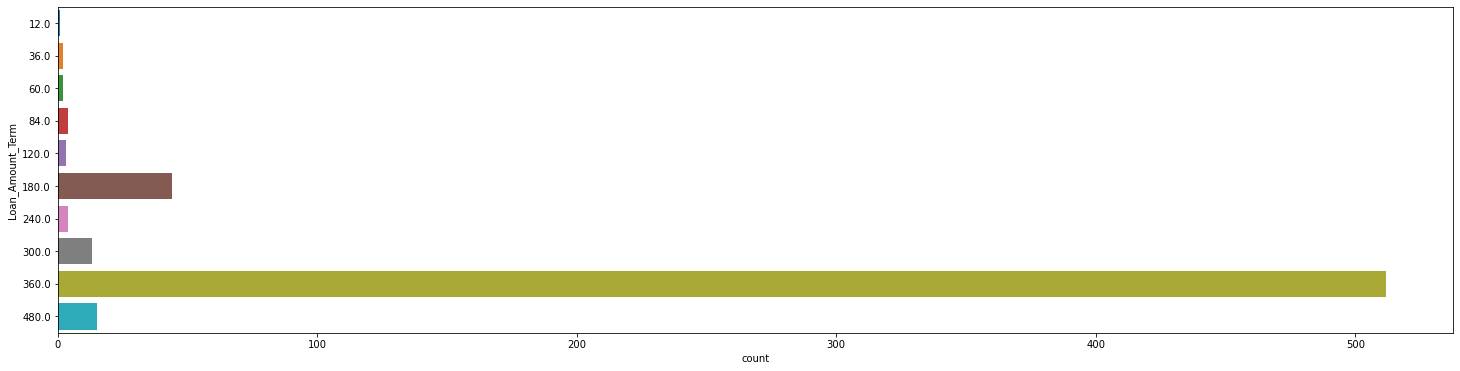

In [47]:
plot_(finance_train, col='Loan_Amount_Term', figsize=(25,6),hue=False)

In [48]:
finance_train.Loan_Amount_Term.value_counts(normalize=True, dropna=False)

360.0    0.833876
180.0    0.071661
480.0    0.024430
NaN      0.022801
300.0    0.021173
240.0    0.006515
84.0     0.006515
120.0    0.004886
60.0     0.003257
36.0     0.003257
12.0     0.001629
Name: Loan_Amount_Term, dtype: float64

The Loan_Amount_Term column is highly skewed towards 360.0. We can choose 360.0 and 180.0 to impute the missing values in proportions of 0.84, 0.16

In [133]:
np.random.seed(23)
finance_train['Loan_Amount_Term'] = finance_train.Loan_Amount_Term.fillna(pd.Series(np.random.choice([360.0, 180.0], p=[0.84, 0.16], size=len(finance_train))))

Converting the term from months into years.

In [53]:
finance_train['Loan_Term_Years'] = finance_train['Loan_Amount_Term'].apply(lambda x: x//12)
finance_train.Loan_Term_Years.value_counts()

30.0    512
15.0     44
40.0     15
25.0     13
20.0      4
7.0       4
10.0      3
5.0       2
3.0       2
1.0       1
Name: Loan_Term_Years, dtype: int64

Let's check the impact of Loan term on the approval status

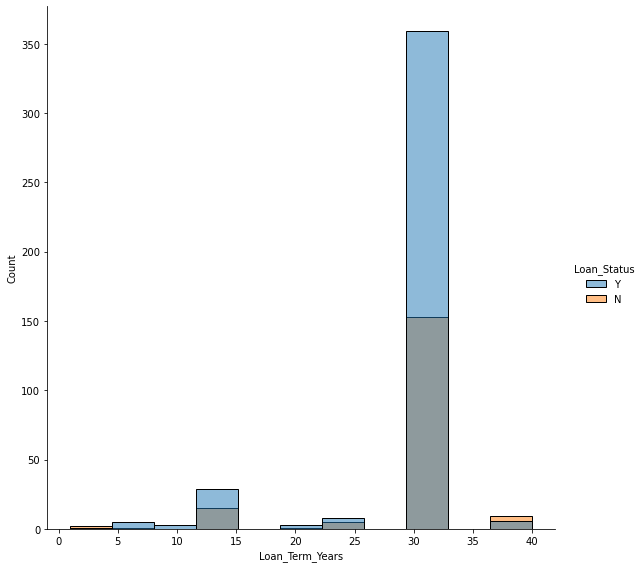

In [54]:
plot_(col='Loan_Term_Years', data=finance_train, hue='Loan_Status')

 in the top two bars, there is again no significant difference between the status of Loan approval.

Label Encoding the Loan_Term

In [57]:
encode = LabelEncoder()
df_finance['Loan_Term_Years_encoded'] = pd.Series(encode.fit_transform(finance_train['Loan_Term_Years']))
df_finance.head(3)

,Loan_Status,Married,Graduate,Property_Area,Applicant_Income_Category,Coapplicant_Income_exists,Male,Dependents,Loan_Term_Years_encoded
0,1,0,1,2,4,0,1,2,8
1,0,1,1,1,4,1,1,3,8
2,1,1,1,2,2,0,1,2,8


Feature-10 : LoanAmount
Loan_Amount is a continous feature and hence we make a scatterplot

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Status'>

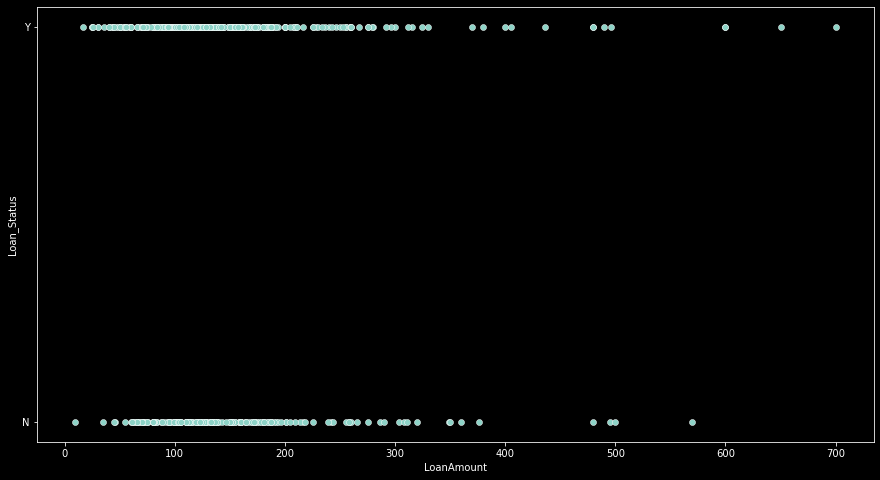

In [58]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='LoanAmount', y='Loan_Status', data=finance_train)

In [59]:
finance_train.LoanAmount.describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

In [60]:
finance_train.LoanAmount.value_counts(dropna=False)

NaN      22
120.0    20
110.0    17
100.0    15
160.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: LoanAmount, Length: 204, dtype: int64

<AxesSubplot:ylabel='Frequency'>

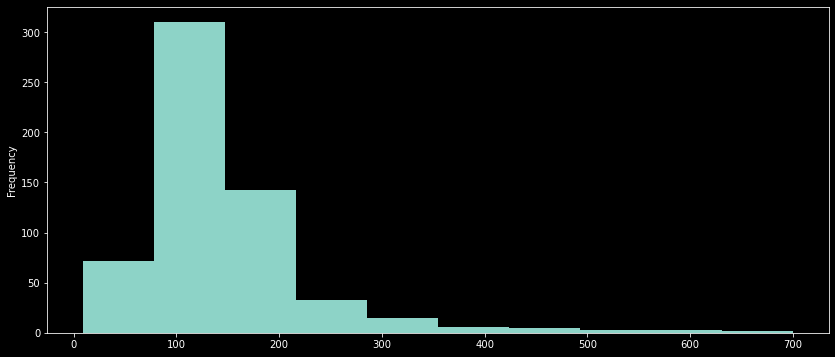

In [61]:
finance_train.LoanAmount.plot(kind='hist', figsize=(14,6))

The distribution of LoanAmount has got a long tail. Therefore, we can replace the missing values with the median of the distribution.

In [62]:
finance_train.LoanAmount.fillna(finance_train.LoanAmount.median(), inplace=True)
finance_train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Loan_Term_Years
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,30.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,30.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,30.0


Because of the possible existence of outliers, we will also discretize the Loan Amount and cut it into 5 categories.

In [63]:
df_finance['Loan_Amount'] = pd.qcut(finance_train.LoanAmount, 5, labels=[1,2,3,4,5])
df_finance.head(3)

,Loan_Status,Married,Graduate,Property_Area,Applicant_Income_Category,Coapplicant_Income_exists,Male,Dependents,Loan_Term_Years_encoded,Loan_Amount
0,1,0,1,2,4,0,1,2,8,3
1,0,1,1,1,4,1,1,3,8,3
2,1,1,1,2,2,0,1,2,8,1



Feature-11 : Self_Employed

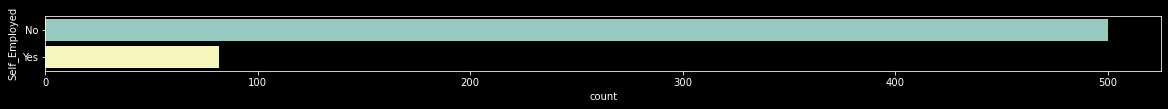

In [64]:
plot_(data=finance_train, col='Self_Employed', figsize=(20,1), hue=False)

In [65]:
finance_train.Self_Employed.value_counts(dropna=False)

No     500
Yes     82
NaN     32
Name: Self_Employed, dtype: int64

In [66]:
finance_train.Self_Employed.value_counts(normalize=True)

No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64

Self_Employed has 25 missing values. Let's impute them in the same proportions as seen in the available data

In [67]:
np.random.seed(23)
finance_train['Self_Employed'] = finance_train.Self_Employed.fillna(pd.Series(np.random.choice(['Yes', 'No'], p=[0.14, 0.86], size=len(finance_train))))
finance_train.Self_Employed.value_counts(dropna=False)

No     526
Yes     88
Name: Self_Employed, dtype: int64

Visualising the impact of Self_Employed on Loan_status

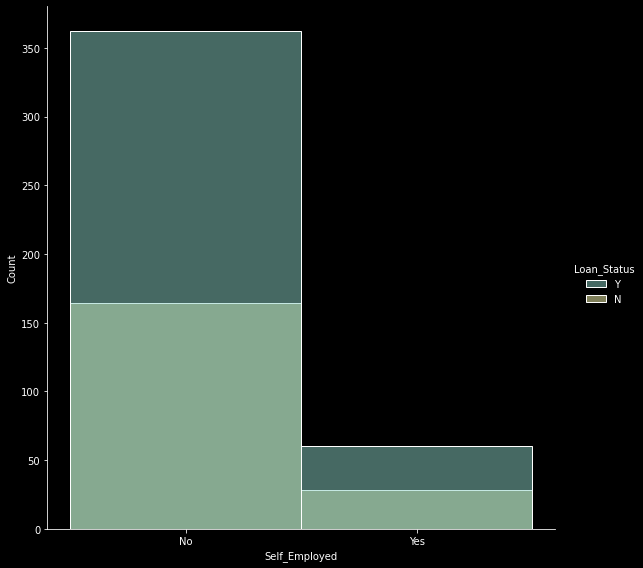

In [69]:
plot_(data=finance_train, col='Self_Employed', hue=True)

In [70]:
# Adding Self_Employed to our new DataFrame after encoding 1 for "YES" and 0 for "NO"

df_finance['Self_Employed'] = finance_train['Self_Employed']
df_finance['Self_Employed'] = np.where(df_finance.Self_Employed == 'Yes', 1, 0)
df_finance.head(6)

,Loan_Status,Married,Graduate,Property_Area,Applicant_Income_Category,Coapplicant_Income_exists,Male,Dependents,Loan_Term_Years_encoded,Loan_Amount,Self_Employed
0,1,0,1,2,4,0,1,2,8,3,0
1,0,1,1,1,4,1,1,3,8,3,0
2,1,1,1,2,2,0,1,2,8,1,1
3,1,1,0,2,1,1,1,2,8,3,0
4,1,0,1,2,4,0,1,2,8,4,0
5,1,1,1,2,4,1,1,1,8,5,1


In [71]:
# Let's see the proportion of Self_employed people whose loan status was approved.

self_approve, not_self_approve = feature_approval_proportion(df_finance, col='Self_Employed')
print("{} % people who were Self-Employed were approved\n{} % people who were not Self-Employed were approved".format(self_approve, not_self_approve))

68.18181818181817 % people who were Self-Employed were approved
68.8212927756654 % people who were not Self-Employed were approved


Feature-12 : Credit_History

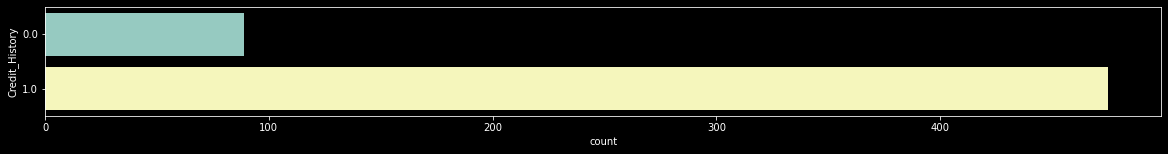

In [72]:
plot_(finance_train, col='Credit_History', hue=False)

In [73]:
finance_train.Credit_History.value_counts(dropna=False)

1.0    475
0.0     89
NaN     50
Name: Credit_History, dtype: int64

Is credit History an important feauture to predict the Loan_Status?
Let's compute the correlation coefficient to get an idea of the importance of this feature after filling the missing values with both 0 and 1 one by one.

In [74]:
print("After filling with 0: ",np.corrcoef(finance_train.Credit_History.fillna(0), df_finance.Loan_Status)[0][1].round(4))

print("After filling with 1: ",np.corrcoef(finance_train.Credit_History.fillna(1), df_finance.Loan_Status)[0][1].round(4))

After filling with 0:  0.4326
After filling with 1:  0.5406


From the correlation values we see that Credit_History has a big impact on Loan_Status and hence we will not make random allocations to fill the null values. Instead we will drop the rows altogether.

In [75]:
df_finance['Credit_History'] = finance_train.Credit_History
df_finance.dropna(subset=['Credit_History'], inplace=True)

#Checking the null values one last time
df_finance.isna().sum()

Loan_Status                  0
Married                      0
Graduate                     0
Property_Area                0
Applicant_Income_Category    0
Coapplicant_Income_exists    0
Male                         0
Dependents                   0
Loan_Term_Years_encoded      0
Loan_Amount                  0
Self_Employed                0
Credit_History               0
dtype: int64

Start Building Machine Learning models.
Now that we have cleaned our data, we can start fitting various Machine Learning models to see which one performs the best.

In [76]:
# CREATING A COPY OF THE DATAFRAME

df_finance_copy = df_finance.copy()

#Seperating the features and labels

df_finance_train = df_finance.drop('Loan_Status', axis=1)
label = df_finance['Loan_Status']

print(df_finance_train.shape, label.shape)

(564, 11) (564,)


Evaluation parameters:  Balanced Accuracy(BAC), Recall(REC)

In [87]:
eval = {
'model_name': [],
'feature_count': [],
'features': [],
'ACC': [],
'BAC': [],
'REC': [],
'AUC': [],
}

In [88]:
# Function to create a DataFrame out of model evaluations 

def model_evaluation(model, fc, f, acc, bac, rec, auc):
    eval['model_name'].append(model)
    eval['feature_count'].append(fc)
    eval['features'].append(f)
    eval['ACC'].append(acc)
    eval['BAC'].append(bac)
    eval['REC'].append(rec)
    eval['AUC'].append(auc)
    
    df_eval = pd.DataFrame({'model_name': eval['model_name'],
                            'feature_count': eval['feature_count'],
                            'feature_names': eval['features'],
                            'ACC': eval['ACC'],
                            'BAC': eval['BAC'],
                            'REC': eval['REC'],
                            'AUC': eval['AUC'] 
                           })
    return df_eval.sort_values(by='BAC', ascending=False).round(3)

Define a function to fit machine learning algorithms
We will be using the algorithms from the scikit-learn library, and almost all algorithms take similar inputs and produce similar outputs.

To prevent writing code multiple times, we will create a function that fits the model and returns the evaluation scores.

In [89]:
def fit_algo(algorithm, x_train, label, cv=10):
    
    # Cross-Validation prediction
    training_predictions = model_selection.cross_val_predict(algorithm,
                                                             x_train,
                                                             label,
                                                             cv=cv,
                                                             n_jobs=-1)
    
    # Evaluating necessary metrics
    acc = metrics.accuracy_score(label, training_predictions)
    bac = metrics.balanced_accuracy_score(label, training_predictions)
    rec = metrics.recall_score(label, training_predictions)
    auc = metrics.roc_auc_score(label, training_predictions)
    
    return acc, bac, rec, auc

In [85]:
feature_set_1 = df_finance_train.columns.tolist()         #Contains all the 11 features
feature_set_1

['Married',
 'Graduate',
 'Property_Area',
 'Applicant_Income_Category',
 'Coapplicant_Income_exists',
 'Male',
 'Dependents',
 'Loan_Term_Years_encoded',
 'Loan_Amount',
 'Self_Employed',
 'Credit_History']

Gaussian NaiveBayes with feature_set_1

In [90]:
acc_nb_f1, bac_nb_f1, rec_nb_f1, auc_nb_f1 = fit_algo(GNB(), x_train=df_finance_train[feature_set_1], label=label)
model_evaluation('GNB_f1', len(feature_set_1), feature_set_1, acc_nb_f1, bac_nb_f1, rec_nb_f1, auc_nb_f1)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719


Logistic Regression with feature_set_1

In [91]:
acc_lr_f1, bac_lr_f1, rec_lr_f1, auc_lr_f1 = fit_algo(LR(random_state=23, solver='liblinear'), df_finance_train[feature_set_1], label)
model_evaluation('LRC_f1', len(feature_set_1), feature_set_1, acc_lr_f1, bac_lr_f1, rec_lr_f1, auc_lr_f1)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719


Random Forest Classifier with feature_set_1

In [92]:
acc_rf_f1, bac_rf_f1, rec_rf_f1, auc_rf_f1 = fit_algo(RFC(random_state=23), df_finance_train[feature_set_1], label)
model_evaluation('RFC_f1', len(feature_set_1), feature_set_1, acc_rf_f1, bac_rf_f1, rec_rf_f1, auc_rf_f1)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
2,RFC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.754,0.685,0.873,0.685


Support Vector Classifier feature_set_1

In [93]:

acc_svc_f1, bac_svc_f1, rec_svc_f1, auc_svc_f1 = fit_algo(SVC(random_state=23, kernel='linear'), df_finance_train[feature_set_1], label)
model_evaluation('SVC_f1', len(feature_set_1), feature_set_1, acc_svc_f1, bac_svc_f1, rec_svc_f1, auc_svc_f1)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
2,RFC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.754,0.685,0.873,0.685


Since, Logistic Regression and Support Vector classifier are the best performing model, let's try to find their feature importanes

i) Logistic Regression

In [94]:
lr_feature_imp = pd.DataFrame(abs((LR(solver='liblinear', random_state=23).fit(df_finance_train, label).coef_).round(4)).reshape(-1,1))

# giving the column a meaningful name
lr_feature_imp.columns = ['importance_magnitude_lr']

# Adding the features column
lr_feature_imp['features'] = pd.Series(df_finance_train.iloc[:,lr_feature_imp.index.tolist()].columns.to_list())

# Changing the index to features
lr_feature_imp =lr_feature_imp.set_index('features').sort_values(by='importance_magnitude_lr', ascending=False)
lr_feature_imp

,importance_magnitude_lr
features,
Credit_History,3.2810
Property_Area,0.4152
Coapplicant_Income_exists,0.4033
Graduate,0.3303
Dependents,0.2499
Married,0.2321
Loan_Term_Years_encoded,0.1100
Self_Employed,0.0813
Male,0.0686


In [95]:
# Choosing the Top 7 features

feature_set_2 = lr_feature_imp.index[0:7].to_list()
feature_set_2

['Credit_History',
 'Property_Area',
 'Coapplicant_Income_exists',
 'Graduate',
 'Dependents',
 'Married',
 'Loan_Term_Years_encoded']

ii) Support Vector Classifier

In [96]:
svc_feature_imp = pd.DataFrame(abs(SVC(random_state=23, kernel='linear').fit(df_finance_train[feature_set_1], label).coef_).reshape(-1,1))
svc_feature_imp.columns = ['importance_magnitude_svc']
svc_feature_imp['features'] = pd.Series(df_finance_train.iloc[:,svc_feature_imp.index.to_list()].columns.to_list())
svc_feature_imp = svc_feature_imp.set_index('features').sort_values(by='importance_magnitude_svc', ascending=False).round(4)
svc_feature_imp

,importance_magnitude_svc
features,
Credit_History,2.0000
Graduate,0.0002
Self_Employed,0.0001
Married,0.0001
Applicant_Income_Category,0.0001
Male,0.0001
Coapplicant_Income_exists,0.0000
Loan_Term_Years_encoded,0.0000
Loan_Amount,0.0000


Checking the correlation analysis to create some more feature sets.

<AxesSubplot:>

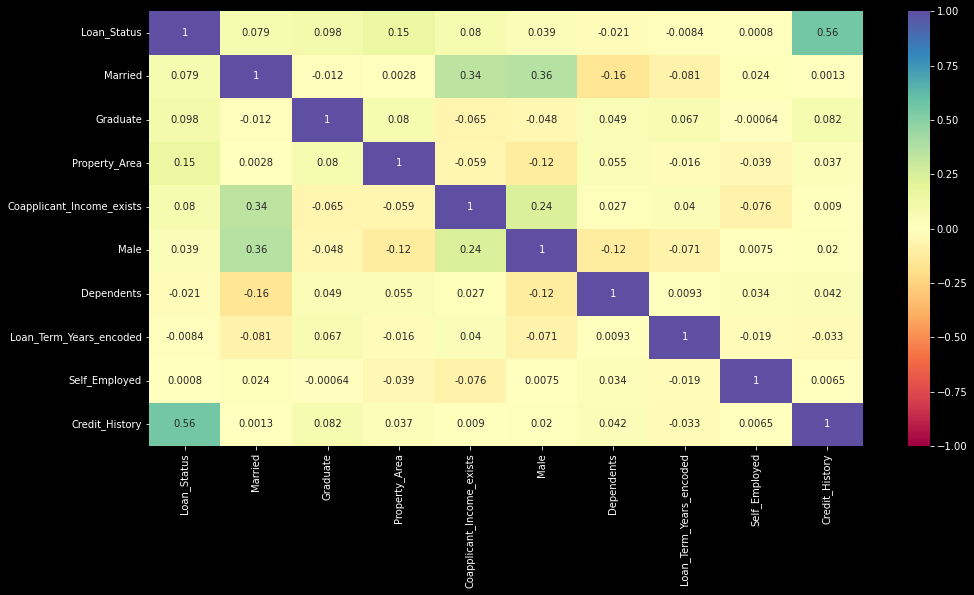

In [97]:
plt.figure(figsize=(16,8))
sns.heatmap(df_finance.corr(), vmin=-1, vmax=1, annot=True, cmap='Spectral')

In [98]:
# Removing less correlated and non-linear features
feature_set_3 = df_finance_train.drop(columns=['Loan_Term_Years_encoded', 'Married', 'Male', 'Dependents']).columns.to_list()
feature_set_3

['Graduate',
 'Property_Area',
 'Applicant_Income_Category',
 'Coapplicant_Income_exists',
 'Loan_Amount',
 'Self_Employed',
 'Credit_History']

Gaussian NaiveBayes with f2 and f3

In [99]:
acc_nb_f2, bac_nb_f2, rec_nb_f2, auc_nb_f2 = fit_algo(GNB(), x_train=df_finance_train[feature_set_2], label=label)
model_evaluation('GNB_f2', len(feature_set_2), feature_set_2, acc_nb_f2, bac_nb_f2, rec_nb_f2, auc_nb_f2)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
2,RFC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.754,0.685,0.873,0.685


In [100]:
acc_nb_f3, bac_nb_f3, rec_nb_f3, auc_nb_f3 = fit_algo(GNB(), x_train=df_finance_train[feature_set_3], label=label)
model_evaluation('GNB_f3', len(feature_set_3), feature_set_3, acc_nb_f3, bac_nb_f3, rec_nb_f3, auc_nb_f3)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
2,RFC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.754,0.685,0.873,0.685


Logistic Regression with f2 and f3

In [101]:
acc_lr_f2, bac_lr_f2, rec_lr_f2, auc_lr_f2 = fit_algo(LR(random_state=23, solver='liblinear', C=0.5), df_finance_train[feature_set_2], label)
model_evaluation('LRC_f2', len(feature_set_2), feature_set_2, acc_lr_f2, bac_lr_f2, rec_lr_f2, auc_lr_f2)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
6,LRC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.817,0.723,0.982,0.723
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
2,RFC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.754,0.685,0.873,0.685


In [102]:
acc_lr_f3, bac_lr_f3, rec_lr_f3, auc_lr_f3 = fit_algo(LR(random_state=23, solver='liblinear', C=0.5), df_finance_train[feature_set_3], label)
model_evaluation('LRC_f3', len(feature_set_3), feature_set_3, acc_lr_f3, bac_lr_f3, rec_lr_f3, auc_lr_f3)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
6,LRC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.817,0.723,0.982,0.723
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
7,LRC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
2,RFC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.754,0.685,0.873,0.685


Random Forest Classifier with f2 and f3

In [103]:
acc_rf_f2, bac_rf_f2, rec_rf_f2, auc_rf_f2 = fit_algo(RFC(random_state=23), df_finance_train[feature_set_2], label)
model_evaluation('RFC_f2', len(feature_set_2), feature_set_2, acc_rf_f2, bac_rf_f2, rec_rf_f2, auc_rf_f2)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
6,LRC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.817,0.723,0.982,0.723
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
7,LRC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
8,RFC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.789,0.705,0.935,0.705
2,RFC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.754,0.685,0.873,0.685


In [104]:
acc_rf_f3, bac_rf_f3, rec_rf_f3, auc_rf_f3 = fit_algo(RFC(random_state=23), df_finance_train[feature_set_3], label)
model_evaluation('RFC_f3', len(feature_set_3), feature_set_3, acc_rf_f3, bac_rf_f3, rec_rf_f3, auc_rf_f3)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
9,RFC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.794,0.731,0.904,0.731
6,LRC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.817,0.723,0.982,0.723
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
7,LRC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
8,RFC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.789,0.705,0.935,0.705
2,RFC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.754,0.685,0.873,0.685


Support Vector Classifier with f2 and f3

In [105]:
acc_svc_f2, bac_svc_f2, rec_svc_f2, auc_svc_f2 = fit_algo(SVC(random_state=23, kernel='linear'), df_finance_train[feature_set_2], label)
model_evaluation('SVC_f2', len(feature_set_2), feature_set_2, acc_svc_f2, bac_svc_f2, rec_svc_f2, auc_svc_f2)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
9,RFC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.794,0.731,0.904,0.731
6,LRC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.817,0.723,0.982,0.723
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
7,LRC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
10,SVC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719
8,RFC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.789,0.705,0.935,0.705


In [106]:
acc_svc_f3, bac_svc_f3, rec_svc_f3, auc_svc_f3 = fit_algo(SVC(random_state=23, kernel='linear'), df_finance_train[feature_set_3], label)
model_evaluation('SVC_f3', len(feature_set_3), feature_set_3, acc_svc_f3, bac_svc_f3, rec_svc_f3, auc_svc_f3)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
9,RFC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.794,0.731,0.904,0.731
6,LRC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.817,0.723,0.982,0.723
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
7,LRC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
10,SVC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.816,0.720,0.982,0.720
11,SVC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719
1,LRC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.814,0.719,0.979,0.719


The evaluation DataFrame is already arranged in descending order with respect to the Balanced Accuracy of various algorithms. Although, Random Forest with feature set 3 gives the best balanced accuracy and auc, it has a very low recall. Also, the difference between the second best performing algorithm(LR) and RFC in their balanced accuracy is a mere 0.001, which for a small testing set of size 367 is pretty insignificant. Therefore, we can choose Logistic Regression with feature set 2 as our predicting algorithms, tune it's hyperparamters further and see what we can do next.

Hyper parameter tuning of Logistic Regression.

In [107]:
param_grid_lr = { 'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
              'class_weight': [None, 'balanced'],
              'solver': ['liblinear', 'newton-cg']
}

grid_search_lr = GridSearchCV(LR(random_state=23), param_grid=param_grid_lr, cv=10, scoring='balanced_accuracy')
grid_search_lr.fit(df_finance_train[feature_set_2], label)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=23),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
                         'class_weight': [None, 'balanced'],
                         'solver': ['liblinear', 'newton-cg']},
             scoring='balanced_accuracy')

In [108]:
grid_search_lr.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'solver': 'liblinear'}

Now we have the best hyperparametes. Let's run the Logistic Regression algorithm with feature set 2 to see if our model has improved.

In [109]:
acc_lr_f2_, bac_lr_f2_, rec_lr_f2_, auc_lr_f2_ = fit_algo(LR(random_state=23, C=0.1, class_weight='balanced', solver='liblinear'), df_finance_train[feature_set_2], label)
model_evaluation('LR_f2_tuned', len(feature_set_2), feature_set_2, acc_lr_f2_, bac_lr_f2_, rec_lr_f2_, auc_lr_f2_)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
9,RFC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.794,0.731,0.904,0.731
12,LR_f2_tuned,7,"[Credit_History, Property_Area, Coapplicant_In...",0.784,0.725,0.886,0.725
6,LRC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.817,0.723,0.982,0.723
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
7,LRC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
10,SVC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.816,0.720,0.982,0.720
11,SVC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
0,GNB_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.812,0.719,0.974,0.719
4,GNB_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.812,0.719,0.974,0.719


Although the Balanced accuracy scores for the tuned model went up, the recall score came down significantly. Therefore, let's also try to tune the hyperparameters of Random forest classifier with feature_set_3 and see if we can get an even better balanced accuracy.

In [113]:
param_grid_rfc = {'criterion': ['gini', 'entropy'],
                  'bootstrap': [True, False],
                  'class_weight': [None, 'balanced'],
                  'max_depth': [None, 10, 50, 100, 500],
                  'min_samples_split': [3,4,5,6],
}

grid_search_rfc = GridSearchCV(RFC(random_state=23), param_grid=param_grid_rfc, cv=10, scoring='balanced_accuracy')
grid_search_rfc.fit(df_finance_train[feature_set_3], label)
grid_search_rfc.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 6}

We have the best hyperparameters for Random Forest. Let's run the algorithm one last time.

In [114]:
model_rfc_tuned = RFC(random_state=23, bootstrap=True, class_weight='balanced', criterion='entropy', max_depth=None, min_samples_split=3)
acc_rf_f3_, bac_rf_f3_, rec_rf_f3_, auc_rf_f3_ = fit_algo(model_rfc_tuned, df_finance_train[feature_set_3], label)
model_evaluation('RFC_f3_tuned', len(feature_set_3), feature_set_3, acc_rf_f3_, bac_rf_f3_, rec_rf_f3_, auc_rf_f3_)

,model_name,feature_count,feature_names,ACC,BAC,REC,AUC
9,RFC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.794,0.731,0.904,0.731
13,RFC_f3_tuned,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.784,0.728,0.881,0.728
14,RFC_f3_tuned,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.784,0.728,0.881,0.728
12,LR_f2_tuned,7,"[Credit_History, Property_Area, Coapplicant_In...",0.784,0.725,0.886,0.725
6,LRC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.817,0.723,0.982,0.723
3,SVC_f1,11,"[Married, Graduate, Property_Area, Applicant_I...",0.816,0.720,0.982,0.720
5,GNB_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
7,LRC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720
10,SVC_f2,7,"[Credit_History, Property_Area, Coapplicant_In...",0.816,0.720,0.982,0.720
11,SVC_f3,7,"[Graduate, Property_Area, Applicant_Income_Cat...",0.816,0.720,0.982,0.720


 Finally,  have managed to increase the balanced accuracy score but the loss in recall when compared to the gain in balanced accuracy is quite significant. Therefore, I would prefer using the Logistic Regression model with feature set 2 for making our predictions.

Making predictions
Checking the missing values in the test set.

In [115]:
finance_test = pd.read_csv("finance_test_data.csv")

In [116]:
finance_test.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [117]:
# We will be using feature_set_2 to make predictions

feature_set_2

['Credit_History',
 'Property_Area',
 'Coapplicant_Income_exists',
 'Graduate',
 'Dependents',
 'Married',
 'Loan_Term_Years_encoded']

We need to Impute the missing values of Credit_history, Dependents, Loan_Amount_term
1. Imputing Dependents - using the same proportion of 0,1,2,3 as was in the training set.

In [120]:
finance_test.Dependents = finance_test.Dependents.replace('3+','3')
np.random.seed(23)
finance_test.Dependents = finance_test.Dependents.fillna(pd.Series(np.random.choice(['0', '1', '2', '3'], p=[0.58, 0.17, 0.17, 0.08], size=len(finance_test))))

2. Imputing Loan_Amount_Term with the top two values: 360.0 and 180.0

In [121]:
np.random.seed(23)
finance_test['Loan_Amount_Term'] = finance_test.Loan_Amount_Term.fillna(pd.Series(np.random.choice([360.0, 180.0], p=[0.84, 0.16], size=len(finance_test))))
finance_test['Loan_Term_Years'] = finance_test['Loan_Amount_Term'].apply(lambda x: x//12)

3. Imputing Credit_History with the same proportions of 0 and 1 as was in the training set.

In [122]:
df_finance_train.Credit_History.value_counts(dropna=False, normalize=True)

1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64

In [123]:
finance_test['Credit_History'] = finance_test.Credit_History.fillna(pd.Series(np.random.choice([0, 1], p=[0.16, 0.84], size=len(finance_test))))

4. Imputing LoanAmount with the median from the training set

In [124]:
finance_test['LoanAmount'] = finance_test.LoanAmount.fillna(finance_train.LoanAmount.median())

# We need to also Label Encode the Loan Amount but since it's not a part of feature_set_2, we will skip this

5. Imputing Self_Employed in the same proportions of "yes" and "no" as the training set.

In [125]:
finance_test['Self_Employed'] = finance_test.Self_Employed.fillna(pd.Series(np.random.choice(['Yes', 'No'], p=[0.14, 0.86], size=len(finance_test))))

Creating an empty DataFrame to which we can add our encoded features one by one.

In [126]:
df_finance_submit = pd.DataFrame()

Adding all the features present in feature_set_2 and encoding them

In [127]:
# 1. Credit History
df_finance_submit['Credit_History'] = finance_test['Credit_History']


# 2. Property Area with the same weights to properties as the training set.
df_finance_submit['Property_Area'] = finance_test.Property_Area.replace({'Semiurban': 3,
                                                                         'Urban': 2,
                                                                         'Rural': 1})


# 3. Coapplicant Income exists or not. 1 for Yes and 0 for No
df_finance_submit['Coapplicant_Income_exists'] = finance_test['CoapplicantIncome']
df_finance_submit['Coapplicant_Income_exists'] = np.where(df_finance_submit.Coapplicant_Income_exists == 0, 0, 1)


# 4. Education status.
df_finance_submit['Graduate'] = finance_test['Education'].replace({'Graduate': 1,
                                                                  'Not Graduate' : 0 })

# 5. Marriage status
df_finance_submit['Married'] = finance_test['Married'].replace({'Yes': 1,
                                                                'No': 0 })

# 6. Dependents. 
df_finance_submit['Dependents'] = finance_test['Dependents'].replace({'1': 3, '0': 2, '2': 1, '3': 0})

In [128]:
# 7. Loan_Term years after label encoding it

encode = LabelEncoder()
df_finance_submit['Loan_Term_Years_encoded'] = pd.Series(encode.fit_transform(finance_test['Loan_Term_Years']))
df_finance_submit.head()

,Credit_History,Property_Area,Coapplicant_Income_exists,Graduate,Married,Dependents,Loan_Term_Years_encoded
0,1.0,2,0,1,1,2,10
1,1.0,2,1,1,1,3,10
2,1.0,2,1,1,1,1,10
3,1.0,2,1,1,1,1,10
4,1.0,2,0,0,0,2,10


In [129]:
final_model = LR(solver='liblinear', random_state=23, C=0.5).fit(df_finance_train[feature_set_2], label)
final_predictions = final_model.predict(df_finance_submit[feature_set_2])
final_predictions[:30]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1])

In [130]:
#Creating a DataFrame to store only the necessary columns to match the schema for the final submission.

final_submission = pd.DataFrame()

final_submission['Loan_ID'] = finance_test['Loan_ID']
final_submission['Loan_Status'] = final_predictions

final_submission.tail(10)

,Loan_ID,Loan_Status
357,LP002952,1
358,LP002954,1
359,LP002962,1
360,LP002965,1
361,LP002969,1
362,LP002971,1
363,LP002975,1
364,LP002980,1
365,LP002986,1
366,LP002989,1
